<a href="https://colab.research.google.com/github/giuseppesalvi/MLinA-Selective-Classification/blob/main/MLinA_Selective_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

ROOTDIR_DATA = "/content/drive/MyDrive/Datasets/Teaching_dataset/"
ROOTDIR_SRC = "/content/drive/MyDrive/Datasets/Teaching_dataset/teaching-MLinAPP/src"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
plt.style.use(os.path.join(ROOTDIR_SRC, "mystyle.mplstyle"))
import sys
sys.path.append(ROOTDIR_SRC)

# Thresholding the uncertain

## Load original and corrupted data

### Cifar10
Do not shuffle the dataset

In [4]:
(cifar10_train, cifar10_test), cifar10_info = tfds.load(
    'cifar10',
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete866P8I/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete866P8I/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


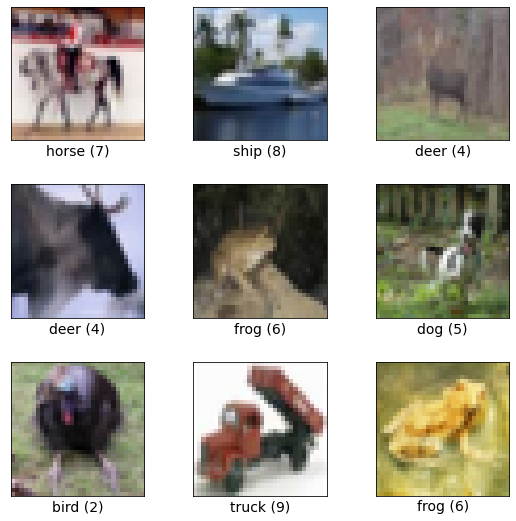

In [5]:
def process_data(image, label):
    return tf.cast(image, tf.float32)/255., tf.one_hot(label, 10, name='label', axis=-1)
    
fig = tfds.show_examples(cifar10_train, cifar10_info)

cifar10_train = cifar10_train.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_train = cifar10_train.cache()
cifar10_train = cifar10_train.batch(128)
cifar10_train = cifar10_train.prefetch(tf.data.AUTOTUNE)

cifar10_test = cifar10_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_test = cifar10_test.cache()
y_true_cifar10_test = np.array([y.numpy() for x, y in cifar10_test])
cifar10_test = cifar10_test.batch(128)
cifar10_test = cifar10_test.prefetch(tf.data.AUTOTUNE)

### Corrupted dataset
Do not shuffle the dataset, make a tf dataset

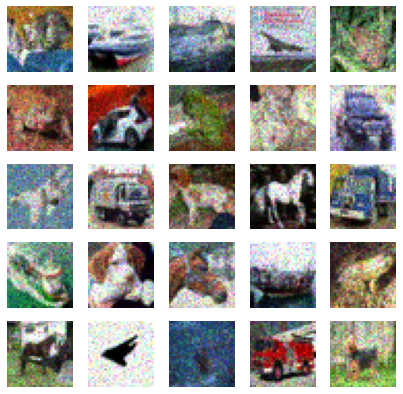

In [6]:
corruption_level = 4
corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/shot_noise.npy"))
corruption = corruption[corruption_level*10000:(corruption_level+1)*10000]
label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy")
)[corruption_level*10000: (corruption_level+1)*10000]

corruption_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corruption))
fig, ax = plt.subplots(5, 5, figsize=(7, 7))
ax = ax.ravel()
j = 0
for x, y in corruption_ds.take(25):
    ax[j].imshow(x.numpy())
    ax[j].axis('off')
    j += 1
corruption_ds = corruption_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
corruption_ds = corruption_ds.cache()
corruption_ds = corruption_ds.batch(128)
corruption_ds = corruption_ds.prefetch(tf.data.AUTOTUNE)

## Load pre-trained CNN

In [7]:
from resnet import ResNet
input_shape = (32, 32, 3)
num_classes = 10
draws = 5 #  with 'all' as TTA policy this means draws*4 total samples
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes, 
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar/checkpoint_cifar10_lr_red"))

## Evaluate on test folds

In [8]:
results_cifar = model.evaluate(cifar10_test, verbose=0)
print("Accuracy on cifar10 test set: {:.2f}".format(results_cifar[1]))

Accuracy on cifar10 test set: 0.83


In [9]:
results_corruption = model.evaluate(corruption_ds, verbose=0)
print("Accuracy on noisy cifar10 test set: {:.2f}".format(results_corruption[1]))

Accuracy on noisy cifar10 test set: 0.30


TTA Wrapper

In [10]:
class TTAWrapper:
    def __init__(self, keras_model, input_shape=(32, 32, 3)):
        super(TTAWrapper, self).__init__()
        self.model = keras_model
        self._input_shape = input_shape
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(metric, multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
        # normalize the output throught 0 and 1
        return (values - values.min()) / (values.max() - values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        # make n=draws predictions, and return the result in a np array
        return np.array([self.predict(inputs) for _ in range(draws)])

    def _average_prediction(self, multiple_preds):
        # to compute the average prediction, calculate the mean on the first 
        # columnt (axis=0), so on the same sample over different predictions 
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
          return multiple_preds

    def _variance(self, multiple_preds):
        # note: if the output of the network is sure, the variance will be higher
        # for example the softmax for class a is always high and for class c and
        # b is always low
        avg_preds = self._average_prediction(multiple_preds)
        return np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def _entropy(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        eps = 1e-5
        return -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)

    def predict_many_times(self, ds, policy, draws=1):
        pred_augmented = list()

        # Different kinds of data augmentations
        # Random Crop
        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(int(self._input_shape[0] - 0.1*self._input_shape[0]),
                                           int(self._input_shape[0] - 0.1*self._input_shape[0])),
                tf.keras.layers.Resizing(self._input_shape[0],
                                         self._input_shape[1])])]
        # Flip
        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal_and_vertical")])
        ]

        # Change Contrast
        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.2, 0.2)])
        ]

        # Zoom
        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(height_factor=(-0.2, .2),
                                           width_factor=(-0.2, .2))])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip
        policies['all'] = sum([policy_random_crop, policy_random_contrast, policy_random_zoom, policy_random_flip], [])

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(draws)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(draws)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(draws)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(draws)], [])
        policies['all'] = sum([policies['all'] for _ in range(draws)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.model.predict(ds_augmented))

        return pred_augmented


In [11]:
tta_model = TTAWrapper(model)

## Make predictions for cifar and corrupted datasets

In [12]:
cifar10_preds = model.predict(cifar10_test)
corruption_preds = model.predict(corruption_ds)
cifar10_many_preds = tta_model.predict_many_times(cifar10_test, "all", draws=draws)
corruption_many_preds = tta_model.predict_many_times(corruption_ds, "all", draws=draws)

## Plot uncertianties distributions

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


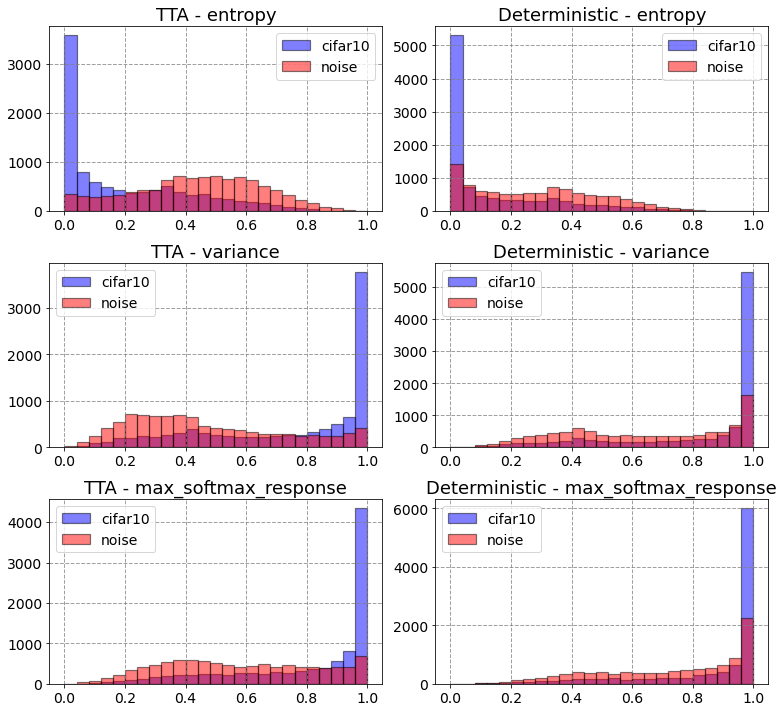

In [13]:
uncertainties = dict()
uncertainties['cifar10_probabilistic'] = (tta_model.uncertainty_metrics(np.array(cifar10_many_preds)), 
                                          cifar10_many_preds, y_true_cifar10_test)
uncertainties['corrupted_probabilistic'] = (tta_model.uncertainty_metrics(np.array(corruption_many_preds)), 
                                            corruption_many_preds, label_corruption)
uncertainties['cifar10_deterministic'] = (tta_model.uncertainty_metrics(cifar10_preds), 
                                          cifar10_preds, y_true_cifar10_test)
uncertainties['corrupted_deterministic'] = (tta_model.uncertainty_metrics(corruption_preds), 
                                            corruption_preds, label_corruption)
fig, axes = plt.subplots(len(tta_model._uncertainty_metrics.keys()), 2, figsize=(11, 10))
for ax, measure in zip(axes, tta_model._uncertainty_metrics.keys()):
    ax[0].set_title(f"TTA - {measure}")
    ax[0].hist(uncertainties['cifar10_probabilistic'][0][measure], 
               color="blue", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2, 
               alpha=0.5, 
               label="cifar10");
    ax[0].hist(uncertainties['corrupted_probabilistic'][0][measure], 
               color="red", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2, 
               alpha=0.5, 
               label="noise");
    ax[0].legend()
    # Deterministic
    ax[1].set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties['cifar10_deterministic'][0][measure], 
               color="blue", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2,
               alpha=0.5, 
               label="cifar10");
    ax[1].hist(uncertainties['corrupted_deterministic'][0][measure], 
               color="red", 
               log=False, 
               bins=25, 
               edgecolor='black', 
               linewidth=1.2, 
               alpha=0.5, 
               label="noise");
    ax[1].legend()
    plt.tight_layout()

Now we can put a threshold $\theta$ on the uncertainties distribution to identify, and eventually remove, those **not-confident** predictions.The following procedure will provide a method to automatically identify such threshold

# Risk-Coverage analysis

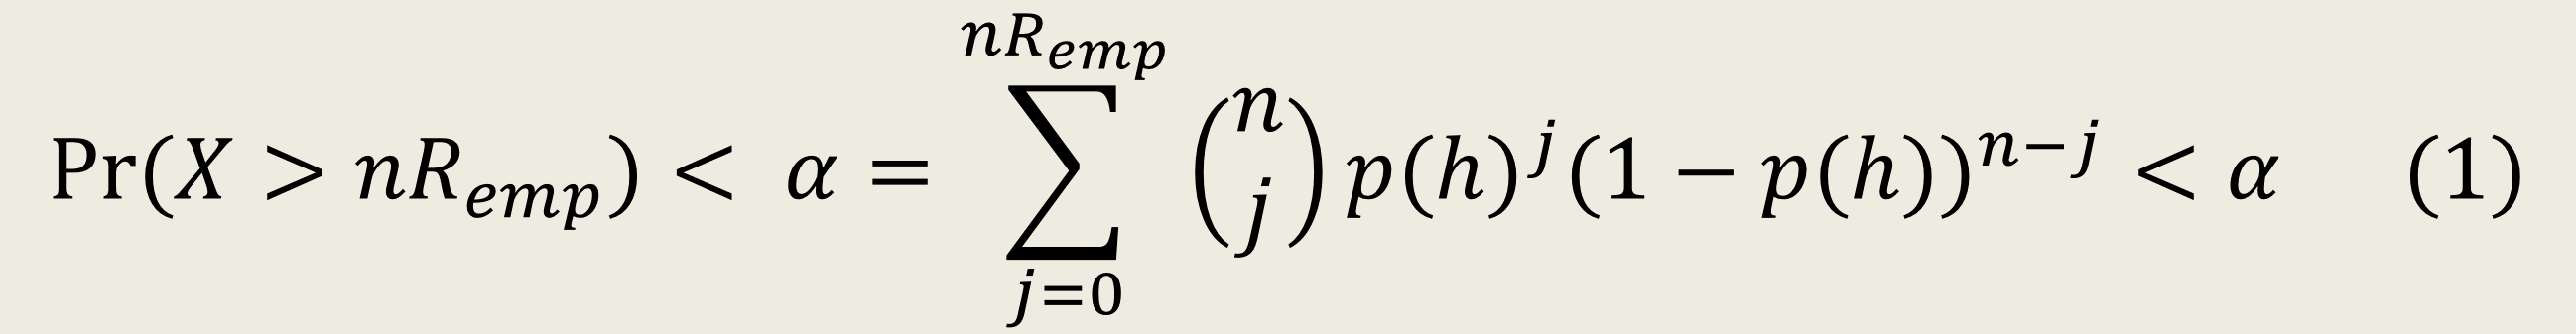

*   This means: **“We want the probability of observing more than $nR_{𝑒𝑚𝑝}$ errors in n trials less than 𝛼”**
*   The inequation (1) depends on **p**, the **true risk** on the data distribution $D$
*   Fixed the empirical risk, we evaluate which p ensures (1) by computing the cumulative density function of a binomial with parameters $p, n, nR_{emp}$


In [14]:
import scipy.stats
def get_risk_bound(n, r_emp, alpha=0.01):
    # n = number of the inliers
    # alpha is the confidence measure
    
    # Try different values for p, possible true risks
    p_array = np.linspace(0, 1, 100)
    # We calculate for each value of p, the cumulativie density function of a 
    # binomial with parameters p, n, nRemp 
    probabilities = np.array(
        [scipy.stats.binom.cdf(r_emp*n, n, p) for p in p_array])
    # Return the values of p that satisfy the inequation (1)
    return p_array[np.where(probabilities < alpha)][0]

Now we can vary the empirical risk thanks to a selection function $𝑔_𝜃 (𝑥)$, based on a confidence measure 𝜅


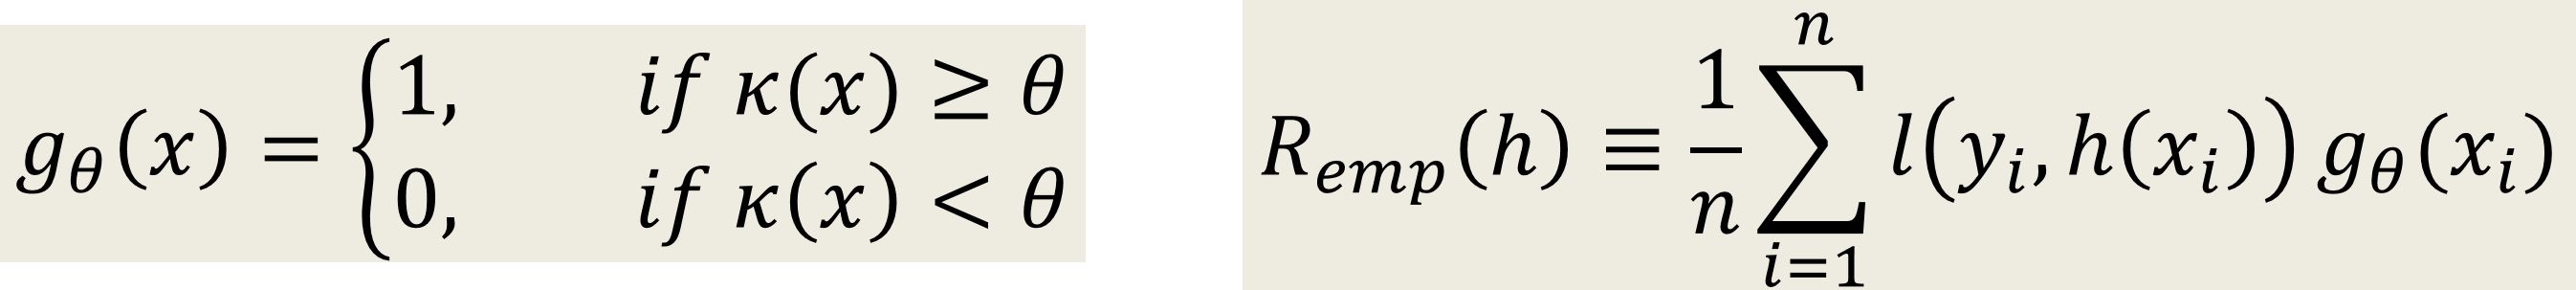

The empirical risk can be traded-off by coverage
*   Coverage is defined as the probability mass of the non-rejected region in $X$ (i.e., the observed number of non-rejected samples)
*   That is, among all the classifiers satisfying $Pr⁡(𝑋>𝑛𝑅_{𝑒𝑚𝑝})< 𝛼$ the best one is that which maximize the coverage
*   The performance profile of the classifier can be specified by risk-coverage curves

Notably, **fixed an acceptable true risk $𝑅^∗$, $\alpha$, and 𝜅 we can obtain the threshold 𝜃 and the corresponding coverage**

**Note that the tailoring of the threshold $\theta$ must be done on the training dataset**

## Function to get $\theta$, i.e., the threshold on the confidence meaure.

In [15]:
def get_theta(y_pred, y_true, r, alpha, confidence_values):
    # y_pred is the array of predicted labels
    # y_true is the array of true labels
    # r is the acceptable true risk
    # confindence_values (k(x)) are the confidence values of the predictions

    # If y_pred and y_true have predictions for different classes, select the
    # prediction with the highest value
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    
    # Try different values of thetas, array of candidates theta
    thetas = np.array([_ for _ in np.linspace(0, 1, 10)])

    coverages = list()
    risk_bounds = list()

    for theta in thetas:
        try:
            # inliers are samples that we are confident enough to classify
            inliers = y_pred[confidence_values > theta]
            inliers_lables = y_true[confidence_values > theta]
            errors = sum(inliers != inliers_lables)
            risk = errors / len(inliers)

            # coverage depends on how many inliers we have
            coverages.append(len(inliers) / len(y_pred))
            risk_bounds.append(get_risk_bound(n=len(inliers), 
                                              r_emp=risk, 
                                              alpha=alpha))
        except ZeroDivisionError:
            coverages.append(0)
            risk_bounds.append(0)
    risk_bounds = np.array(risk_bounds)
    # filter depending on the empirical acceptable risk r
    indexes = risk_bounds == risk_bounds[risk_bounds <= r][0]
    if sum(indexes) > 1:
        first_true = np.where(indexes == True)[0][0]
        indexes = np.zeros(len(indexes), dtype=bool)
        indexes[first_true] = True
    return float(thetas[indexes]), float(np.array(coverages)[indexes]), float(risk_bounds[indexes]) 

Since **that the setting of the threshold $\theta$ must be done on the training dataset**, we predict the **train fold of the cifar10**

Let's extract 10000 random images from the cifar10

In [16]:
cifar10_train = cifar10_train.unbatch()
cifar10_train = cifar10_train.shuffle(buffer_size=50000, reshuffle_each_iteration=False)
cifar10_train = cifar10_train.take(10000)
y_true_cifar10_train = np.array([y.numpy() for x, y in cifar10_train])
cifar10_train = cifar10_train.batch(128)
cifar10_preds = model.predict(cifar10_train)
cifar10_many_preds = tta_model.predict_many_times(cifar10_train, "all", draws=draws)

## Explore all corruptions for all corruption levels with a mixed dataset 

In [17]:
PREDICT = False 
n_samples = 5000
if PREDICT:
    confidence_data_all_corruptions = dict()
    label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy"))
    # For all the corruption levels
    for corruption_level in [0, 1, 2, 3, 4]:
        confidence_data_all_corruptions[corruption_level] = dict()
        # Explore all corruptions
        for filepath in glob.glob(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/*.npy")):
            corruption_type = os.path.basename(filepath).split('.')[0]
            # skipt the file with the labels, that is present in the same folder
            if "labels" in corruption_type:
                continue
            confidence_data_all_corruptions[corruption_level][corruption_type] = dict()
            print("Doing {}-{}".format(corruption_type, corruption_level))
            corruption = np.load(filepath)
            # First n_samples samples from corrupted dataset are used as training set to compute the threshold
            corruption = corruption[corruption_level*10000:corruption_level*10000+n_samples]
            label_corr = label_corruption[corruption_level*10000:corruption_level*10000+n_samples]
            corruption_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corr))
            corruption_ds = corruption_ds.map(
                process_data, num_parallel_calls=tf.data.AUTOTUNE)
            corruption_ds = corruption_ds.cache()
            corruption_ds = corruption_ds.batch(128)
            corruption_ds = corruption_ds.prefetch(tf.data.AUTOTUNE)
            # Create a mixed probabilistic dataset
            print("For the mixed probabilistic dataset")
            a = cifar10_many_preds
            b = tta_model.predict_many_times(corruption_ds, 
                                             "all", 
                                             draws=draws)
            confidence_data_all_corruptions[corruption_level][corruption_type]['probabilistic'] = (
                tta_model.uncertainty_metrics(
                    np.concatenate((a, b), axis=1)), 
                np.concatenate((a, b), axis=1),
                np.concatenate((np.argmax(y_true_cifar10_train, axis=1), 
                                label_corr), axis=0)
            )
            # Create a mixed deterministic dataset
            print("For the mixed deterministic dataset")
            a = cifar10_preds
            b = model.predict(corruption_ds)       
            confidence_data_all_corruptions[corruption_level][corruption_type]['deterministic'] = (
                tta_model.uncertainty_metrics(
                    np.concatenate((a, b), axis=0)), 
                np.concatenate((a, b), axis=0),
                np.concatenate((np.argmax(y_true_cifar10_train, axis=1),
                                label_corr), axis=0)
            )
            print("")
    filepath = os.path.join(ROOTDIR_DATA, "confidence_data_all_corruptions.pickle")
    with open(filepath, "wb") as fp:
        pickle.dump(confidence_data_all_corruptions, fp)
else:
    filepath = os.path.join(ROOTDIR_DATA, "confidence_data_all_corruptions.pickle")
    with open(filepath, "rb") as fp:
        confidence_data_all_corruptions = pickle.load(fp)

### Fix corruption level

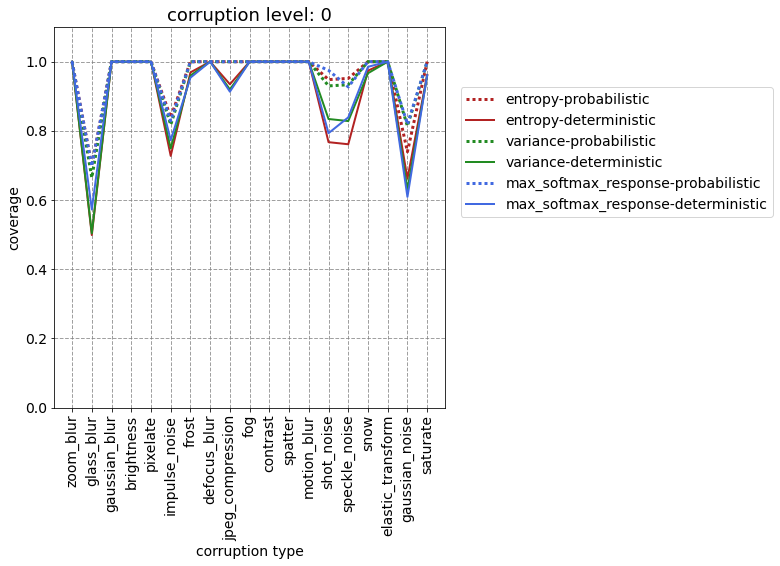

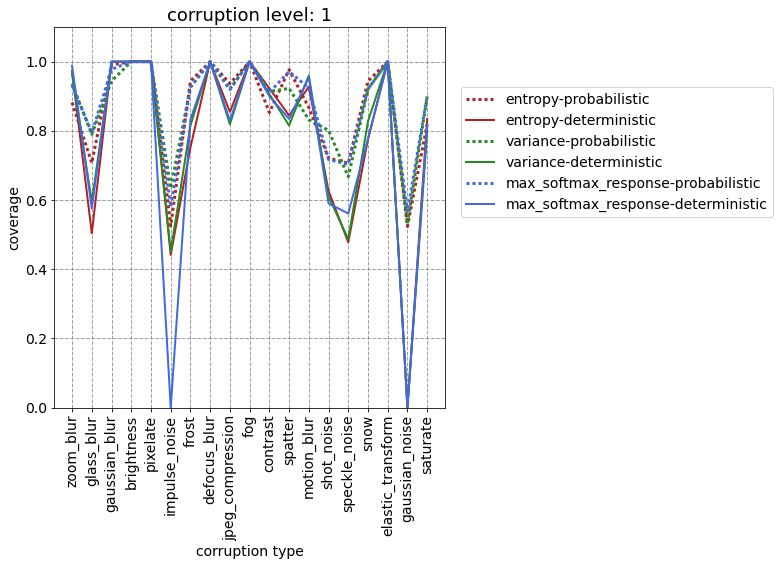

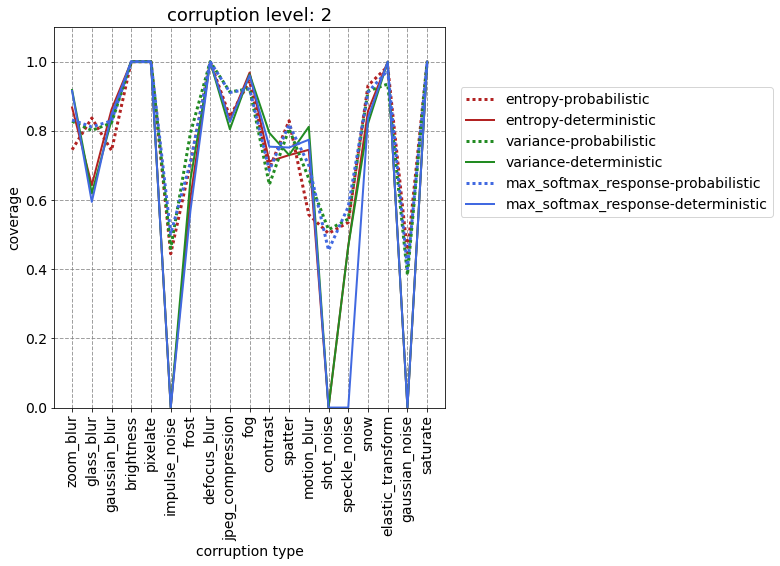

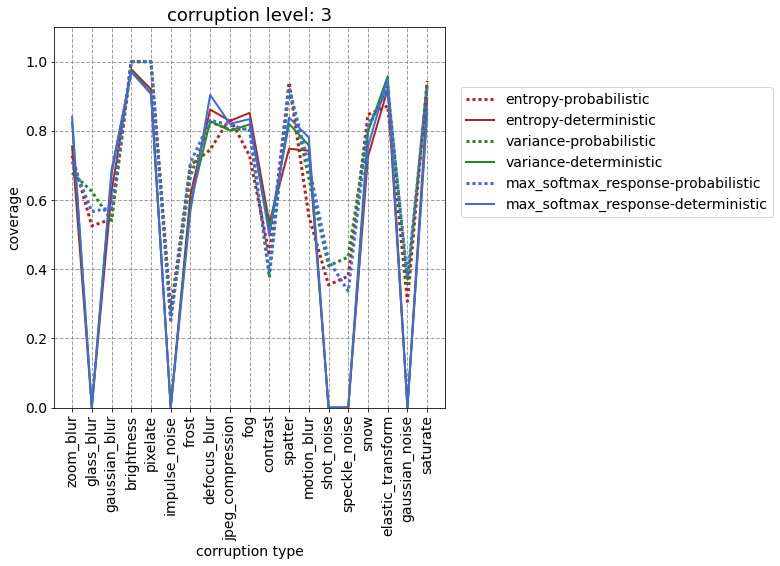

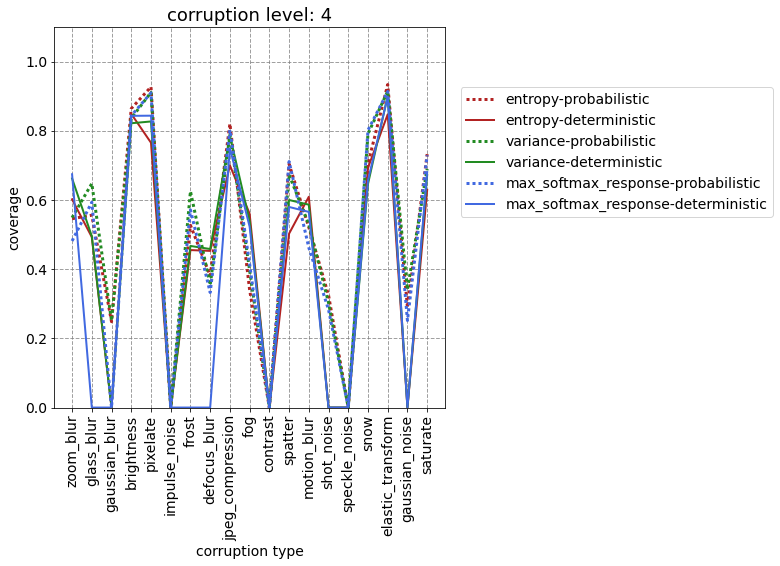

In [18]:
risk = 0.2
stats = dict()
# Loop on corruption level
for level in confidence_data_all_corruptions.keys():
    # Prepare dict
    for key in tta_model._uncertainty_metrics.keys():
        key = '-'.join([key, "probabilistic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
        key = '-'.join([(key).split('-')[0], "deterministic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
    # Loop on corruption type
    for corruption_type in confidence_data_all_corruptions[level].keys():
        # Loop on deterministic or probabilistic
        for uncertainty_type, uncertainty_data in confidence_data_all_corruptions[level][corruption_type].items():
            y_true = uncertainty_data[2]
            y_preds = uncertainty_data[1]
            if len(y_preds.shape) > 2:
                y_preds = np.mean(y_preds, axis=0)
            for measure_key in uncertainty_data[0].keys():
                if measure_key == 'entropy':
                    measure = 1 - uncertainty_data[0][measure_key]
                else:
                    measure = uncertainty_data[0][measure_key]

                (theta, coverage, risk_bound) = get_theta(y_preds,
                                                          y_true,
                                                          risk, 
                                                          0.01, 
                                                          measure)
                stats['-'.join([measure_key, uncertainty_type])]['theta'].append(theta)
                stats['-'.join([measure_key, uncertainty_type])]['coverage'].append(coverage)
                stats['-'.join([measure_key, uncertainty_type])]['risk_bound'].append(risk_bound)
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    colors = ['firebrick', 'forestgreen', 'royalblue']
    j = 0
    for metric in tta_model._uncertainty_metrics.keys():
        ax.plot(stats['-'.join([metric, "probabilistic"])]['coverage'], 
                label='-'.join([metric, "probabilistic"]),
                linewidth=3,
                color=colors[j],
                linestyle=(0, (1, 1)))
        ax.plot(stats['-'.join([metric, "deterministic"])]['coverage'],
                linewidth=2,
                color=colors[j],
                label='-'.join([metric, "deterministic"]))
        j += 1
    ax.legend(loc=(1.04, 0.5))
    ax.set_xlabel('corruption type')
    ax.set_ylabel('coverage')
    ax.set_ylim([0, 1.1])
    ax.set_xticks(np.arange(len(stats['-'.join([metric, "probabilistic"])]['coverage'])))
    ax.set_xticklabels(confidence_data_all_corruptions[0].keys(), rotation=90)
    ax.set_title("corruption level: {}".format(level))

### Fix corruption type

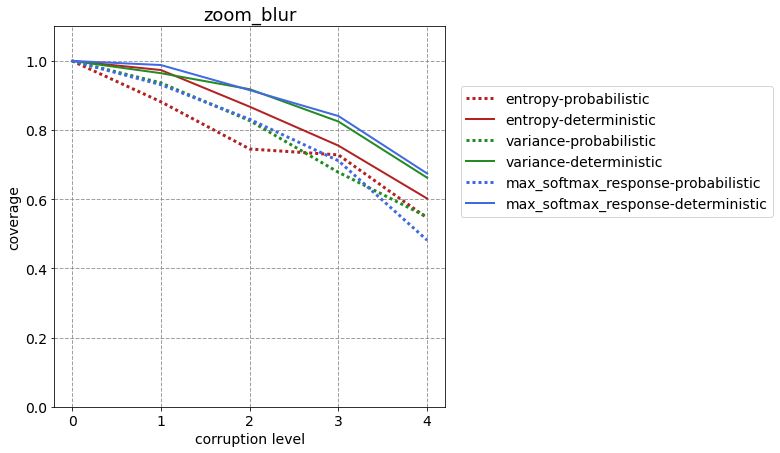

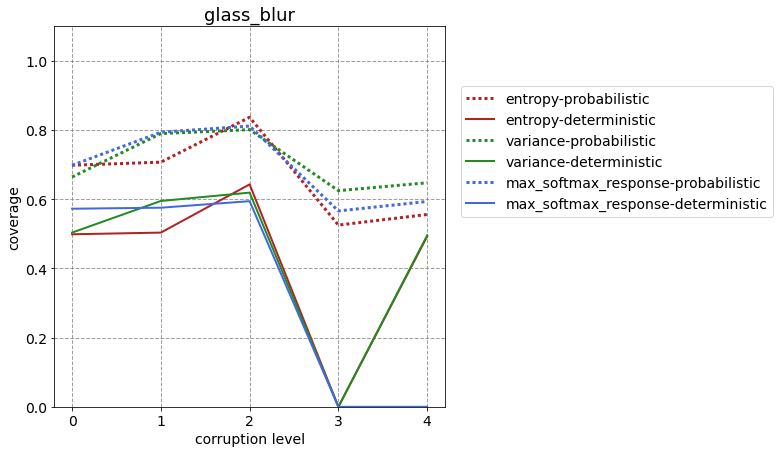

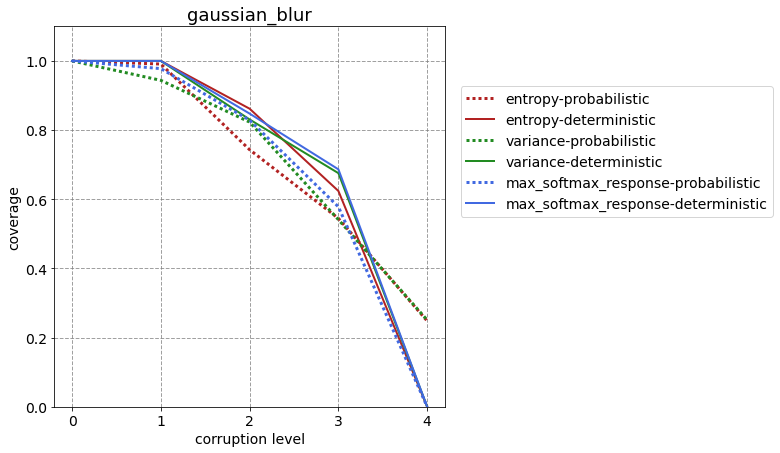

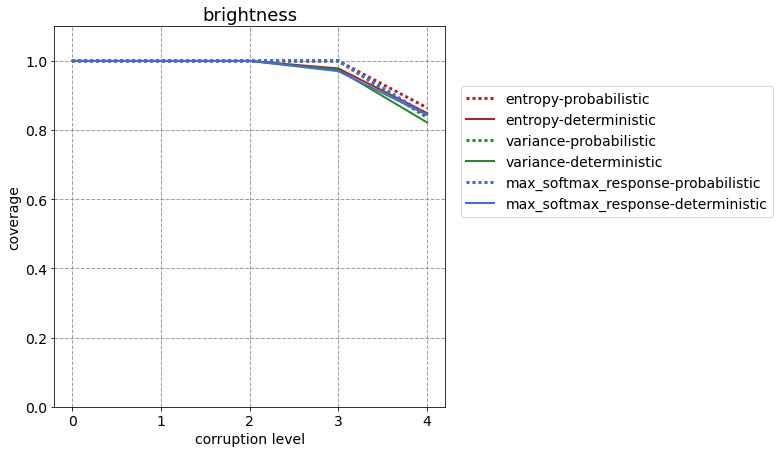

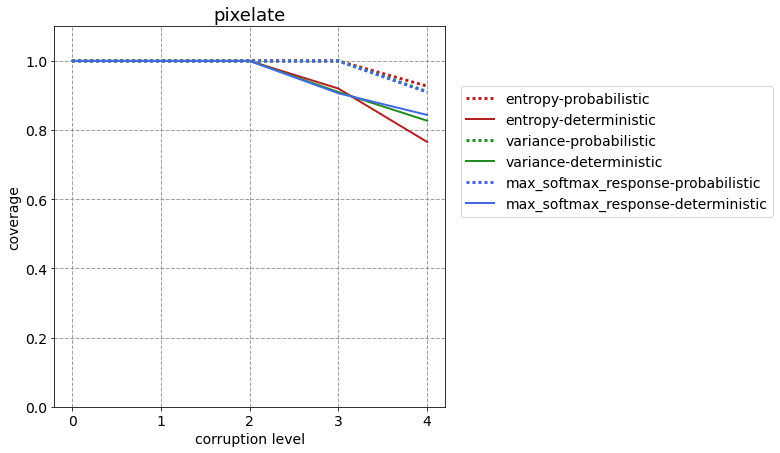

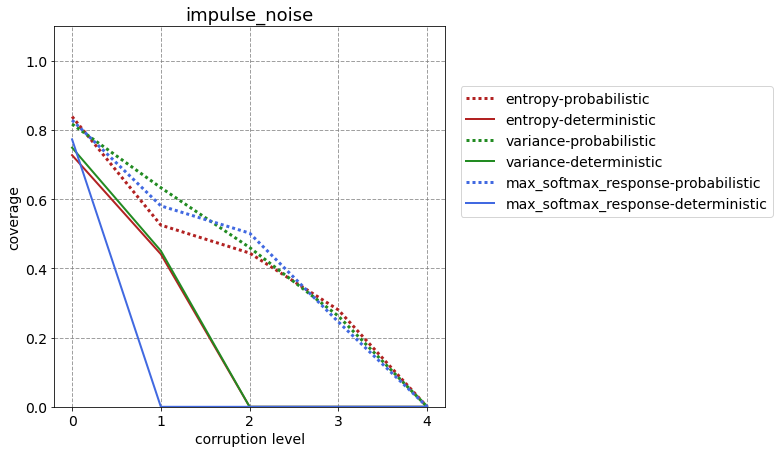

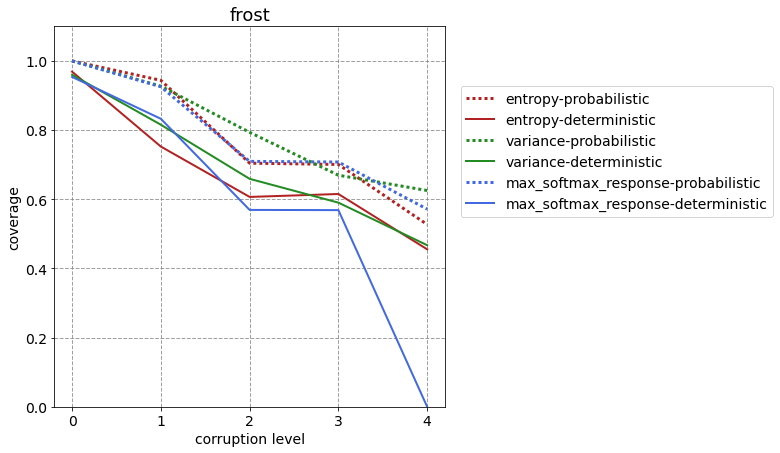

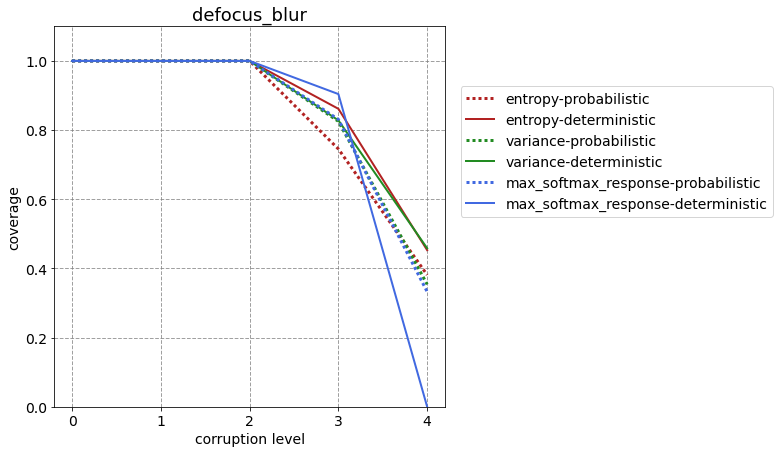

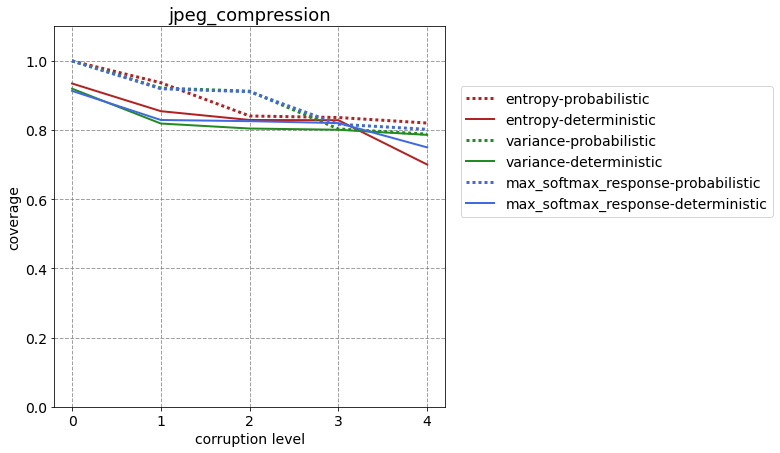

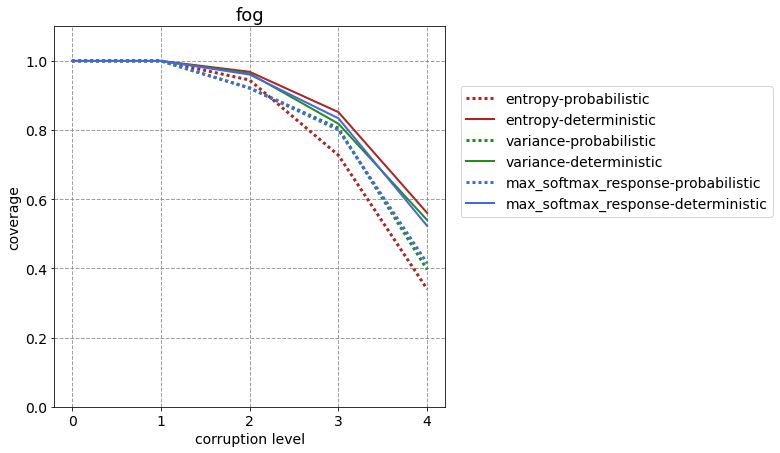

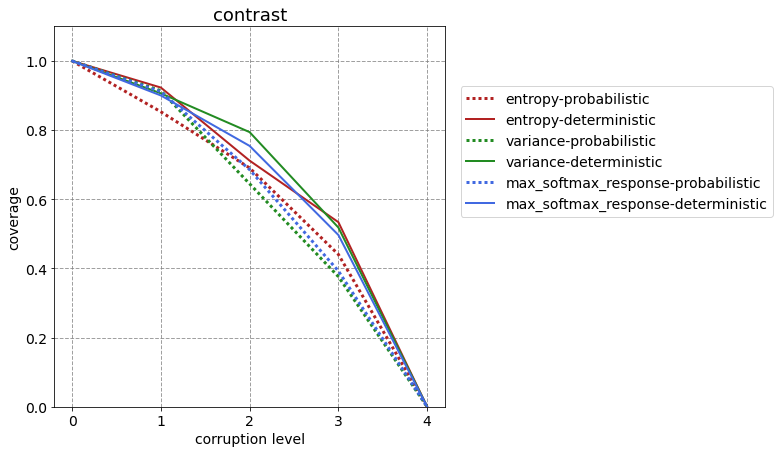

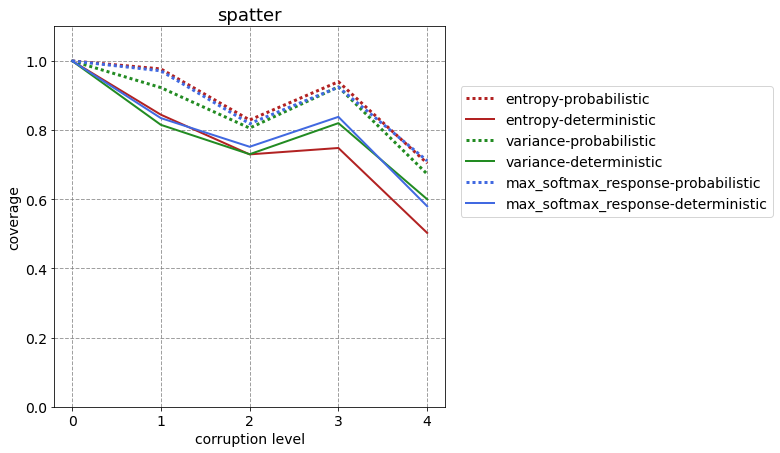

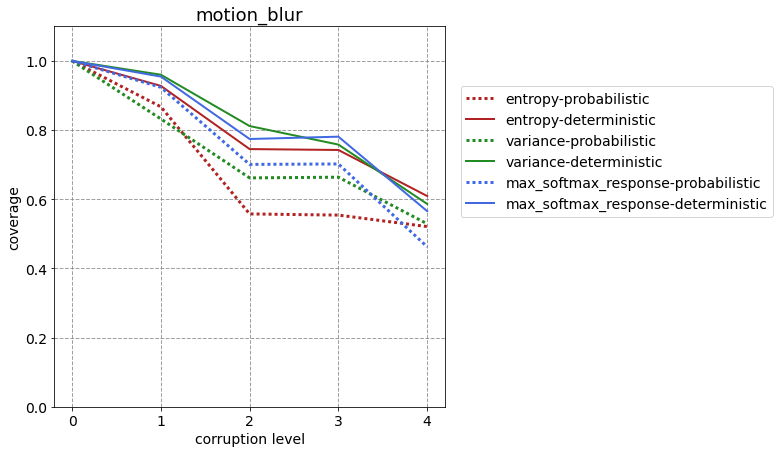

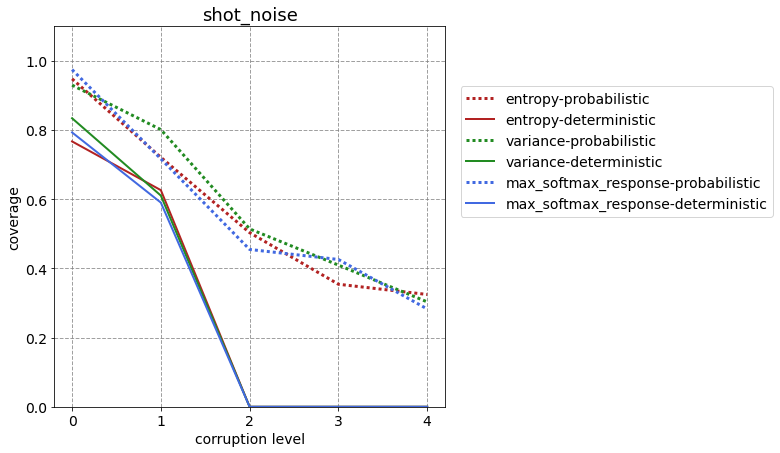

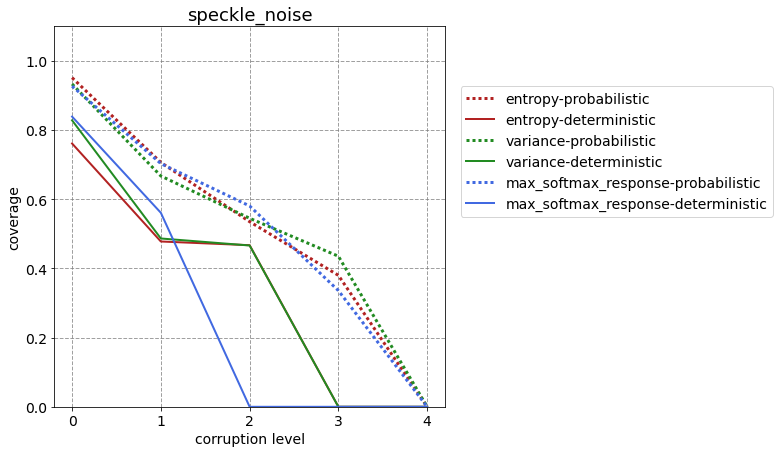

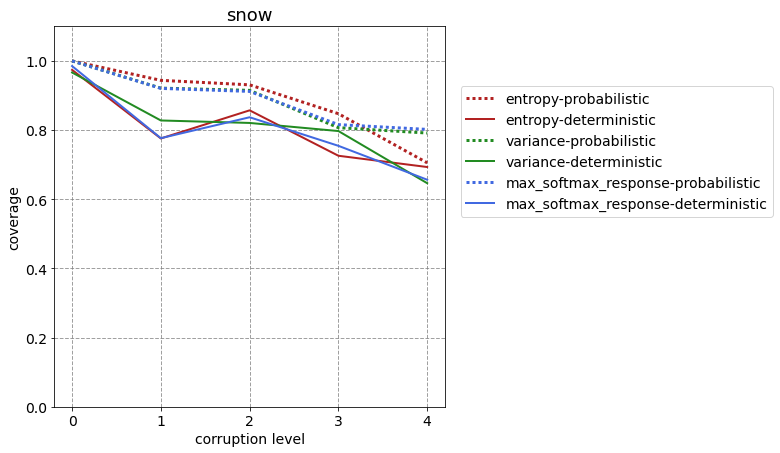

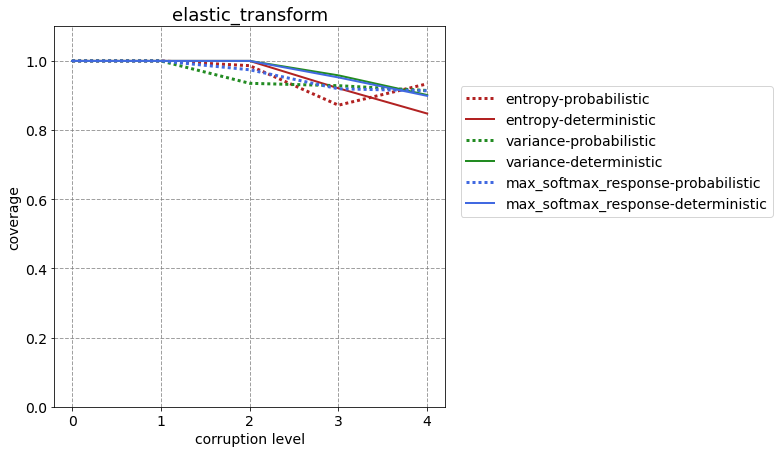

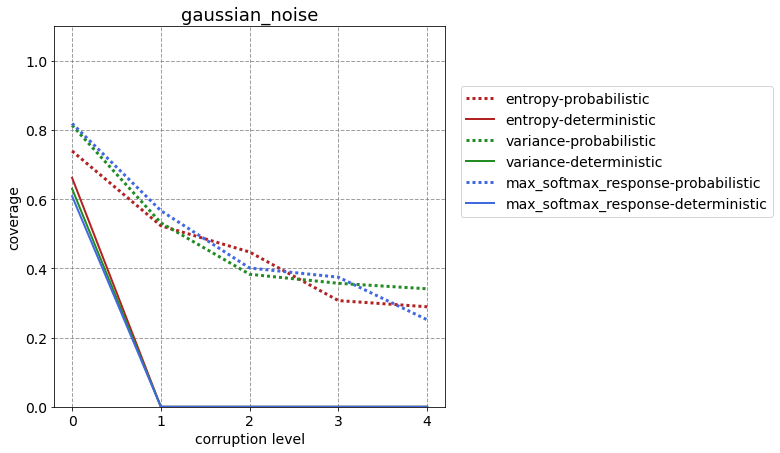

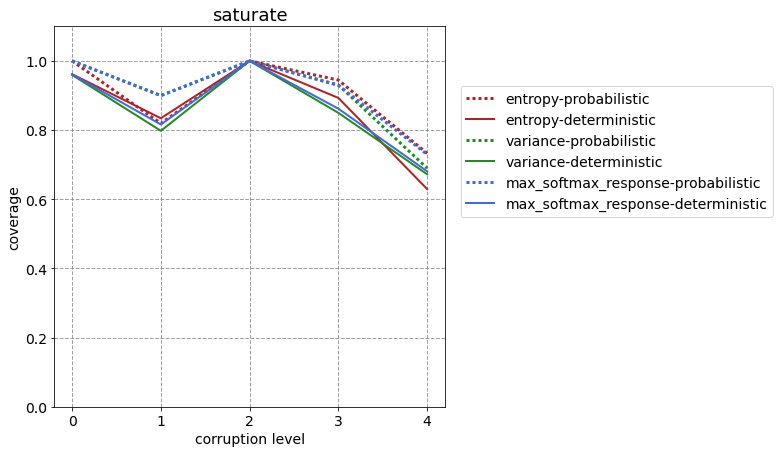

In [19]:
risk = 0.2
for corruption_type in confidence_data_all_corruptions[level].keys():
    stats = dict()
    # Prepare dict
    for key in tta_model._uncertainty_metrics.keys():
        key = '-'.join([key, "probabilistic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
        key = '-'.join([(key).split('-')[0], "deterministic"])
        stats[key] = dict()
        stats[key]['theta'] = list()
        stats[key]['coverage'] = list()
        stats[key]['risk_bound'] = list()
    # Fix corruption type and loop on deterministic or probabilistic
    for level in [0, 1, 2, 3, 4]:
        for uncertainty_type, uncertainty_data_by_corruption in confidence_data_all_corruptions[level][corruption_type].items():
            y_true = uncertainty_data_by_corruption[2]
            y_preds = uncertainty_data_by_corruption[1]
            if len(y_preds.shape) > 2:
                y_preds = np.mean(y_preds, axis=0)
            for measure_key in uncertainty_data_by_corruption[0].keys():
                if measure_key == 'entropy':
                    measure = 1 - uncertainty_data_by_corruption[0][measure_key]
                else:
                    measure = uncertainty_data_by_corruption[0][measure_key]

                (theta, coverage, risk_bound) = get_theta(y_preds,
                                                          y_true,
                                                          risk, 
                                                          0.01, 
                                                          measure)
                stats['-'.join([measure_key, uncertainty_type])]['theta'].append(theta)
                stats['-'.join([measure_key, uncertainty_type])]['coverage'].append(coverage)
                stats['-'.join([measure_key, uncertainty_type])]['risk_bound'].append(risk_bound)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    colors = ['firebrick', 'forestgreen', 'royalblue']
    j = 0
    for metric in tta_model._uncertainty_metrics.keys():
        ax.plot(stats['-'.join([metric, "probabilistic"])]['coverage'], 
                label='-'.join([metric, "probabilistic"]),
                linewidth=3,
                color=colors[j],
                linestyle=(0, (1, 1)))
        ax.plot(stats['-'.join([metric, "deterministic"])]['coverage'],
                linewidth=2,
                color=colors[j],
                label='-'.join([metric, "deterministic"]))
        j += 1
    ax.legend(loc=(1.04, 0.5))
    ax.set_xlabel('corruption level')
    ax.set_ylabel('coverage')
    ax.set_xticks(np.arange(len(stats['-'.join([metric, "probabilistic"])]['coverage'])))
    ax.set_title(corruption_type)
    ax.set_ylim([0, 1.1])

### Now compute coverage varying the risk for the gaussian_noise corruption type with corruption level 3

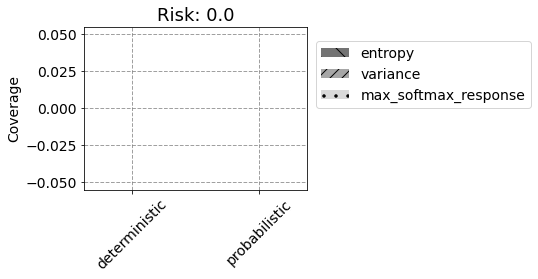

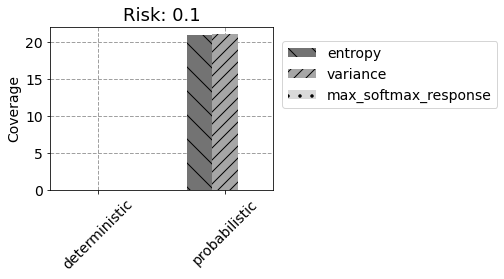

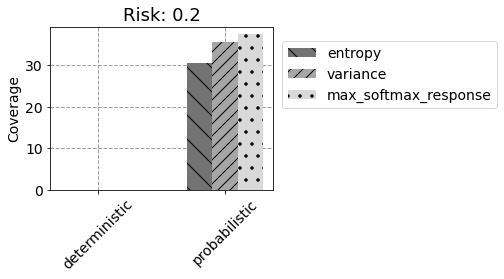

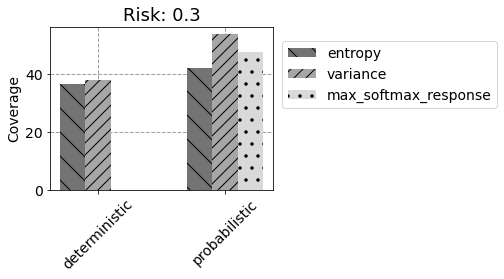

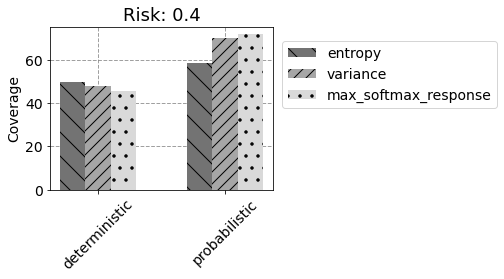

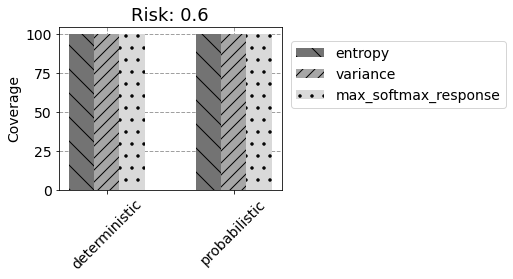

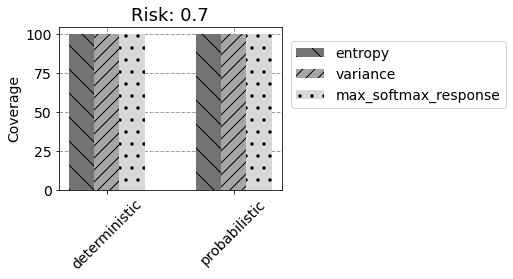

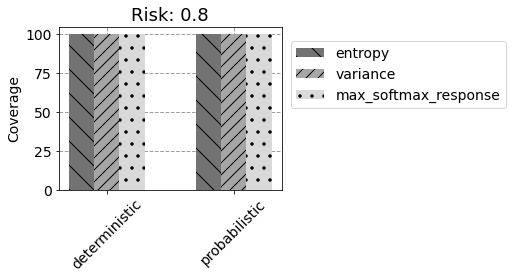

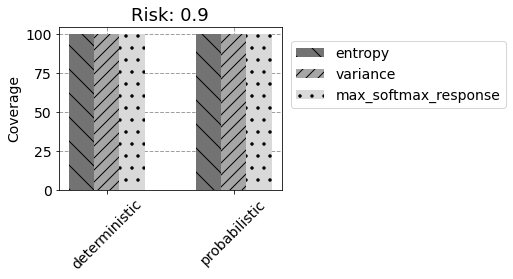

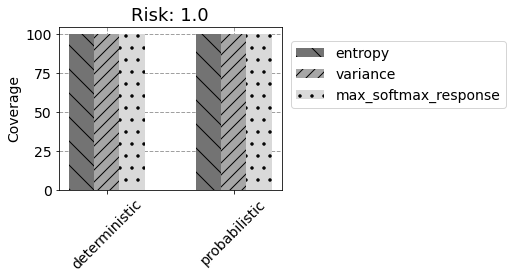

In [20]:
risks = np.linspace(0, 1, 10)
coverage_stats = dict()
level = 3
corruption_type = "gaussian_noise"
for risk in risks:
    risk = np.round(risk, decimals=1)
    coverage_stats[risk] = dict()
    for dataset in confidence_data_all_corruptions[level][corruption_type].keys():
        coverage_stats[risk][dataset] = dict()
        y_true = confidence_data_all_corruptions[level][corruption_type][dataset][2]
        y_preds = np.array(confidence_data_all_corruptions[level][corruption_type][dataset][1])
        if len(y_preds.shape) > 2:
            y_preds = np.mean(y_preds, axis=0)
        for measure_key in confidence_data_all_corruptions[level][corruption_type][dataset][0].keys():
            if measure_key == 'entropy':
                measure = 1 - confidence_data_all_corruptions[level][corruption_type][dataset][0][measure_key]
            else:
                measure = confidence_data_all_corruptions[level][corruption_type][dataset][0][measure_key]

            (theta, coverage, risk_bound) = get_theta(y_preds,
                                                      y_true,
                                                      risk, 
                                                      0.01, 
                                                      measure)
            coverage_stats[risk][dataset][measure_key] = dict()
            coverage_stats[risk][dataset][measure_key]['theta'] = theta
            coverage_stats[risk][dataset][measure_key]['coverage'] = coverage
            coverage_stats[risk][dataset][measure_key]['risk_bound'] = risk_bound


positions = np.arange(1, 3)
deltas = [-0.2, 0, 0.2]
hatches = ['\\', '//', '.']
colors = [0.45, 0.65, 0.85]
width = 0.2
for risk in coverage_stats.keys():
    k = 0
    coverage_data = coverage_stats[risk]
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    for dataset, confidence in sorted(coverage_data.items()):
        j = 0
        for metric in list(tta_model._uncertainty_metrics.keys()):
            if k==0:
                label = metric
            else:
                label = None
            ax.bar(positions[k] + deltas[j], confidence[metric]['coverage']*100, 
                   width=width,
                   color=[colors[j]]*3,
                   hatch=hatches[j],
                   label=label,
                   zorder=2)
            j += 1
        k +=1
    ax.legend(loc=(1.04, 0.5))
    ax.set_xticks(positions)
    ax.set_xticklabels(sorted(confidence_data_all_corruptions[level][corruption_type].keys()), rotation=45);
    ax.set_title("Risk: {}".format(risk));
    ax.set_ylabel("Coverage".format(risk));

### Lastly, let's evaluate on the test partiton for the above given corruption type, level and risk=0.2. Also consider variance as confidence metric

Plot a confusion matrix of the results with & without those samples identified as not confident

We get theta from the above computation on the traing set

In [21]:
risk = 0.2
theta = coverage_stats[risk]['probabilistic']['variance']['theta']
coverage = coverage_stats[risk]['probabilistic']['variance']['coverage']

In [22]:
filepath = os.path.join(ROOTDIR_DATA, "CIFAR-10-C/gaussian_noise.npy")
corruption = np.load(filepath)
# First n_samples samples from corrupted dataset are used as training set to compute the threshold
# So from n_samples to end can be used to test
corruption = corruption[corruption_level*10000+n_samples:corruption_level*10000+10000]
label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy"))
label_corr = label_corruption[corruption_level*10000+n_samples:corruption_level*10000+10000]
corruption_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corr))
corruption_ds = corruption_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
corruption_ds = corruption_ds.cache()
corruption_ds = corruption_ds.batch(128)
corruption_ds = corruption_ds.prefetch(tf.data.AUTOTUNE)
# Create a mixed probabilistic dataset
# Now we are working on the images of the test fold of cifar10
a = tta_model.predict_many_times(cifar10_test, "all", draws=draws)
b = tta_model.predict_many_times(corruption_ds, 
                                 "all", draws=draws)
uncertainty_data = tta_model.uncertainty_metrics(np.concatenate((a, b), axis=1))
preds = np.concatenate((a, b), axis=1)

Done entropy
Done variance
Done max_softmax_response


In [23]:
preds_averaged = np.mean(preds, axis=0)

In [24]:
true_labels = np.hstack((np.argmax(y_true_cifar10_test, axis=1),
                        label_corruption[corruption_level*10000+n_samples:corruption_level*10000+10000]))

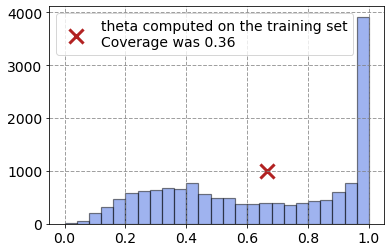

In [25]:
variance = uncertainty_data['variance']
fig, ax = plt.subplots(1, 1)
ax.hist(variance,
        color="royalblue", 
        log=False, 
        bins=25, 
        edgecolor='black', 
        linewidth=1.2, 
        alpha=0.5);
ax.scatter(theta, 1000, 
           marker='x', 
           color="firebrick", 
           s=200, 
           linewidth=3,
           label="theta computed on the training set\nCoverage was {:.2f}".format(coverage));
ax.legend();


In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import cm as plt_cmap
def seaborn_cm(cm, ax, tick_labels, fontsize=14):

    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm)
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=45)

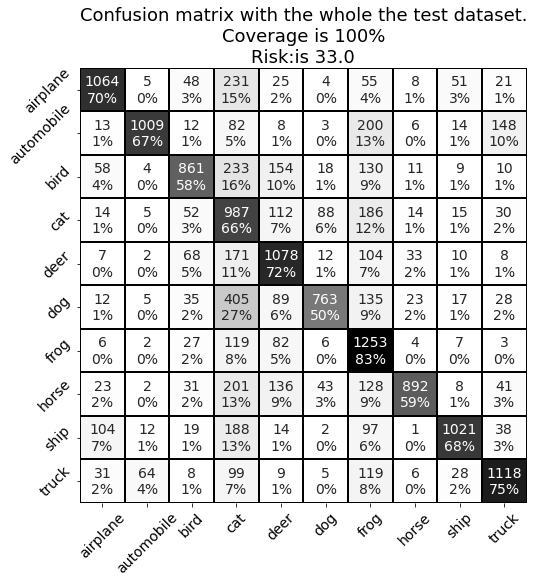

In [27]:
cm = confusion_matrix(true_labels, 
                      np.argmax(preds_averaged, axis=1))
categorical_labels = ["airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck"]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
seaborn_cm(cm, ax, categorical_labels)
ax.set_title("Confusion matrix with the whole the test dataset.\nCoverage is 100%\nRisk:is {:.1f}".format(
    100 - np.sum(np.diag(cm)) / len(variance) * 100));

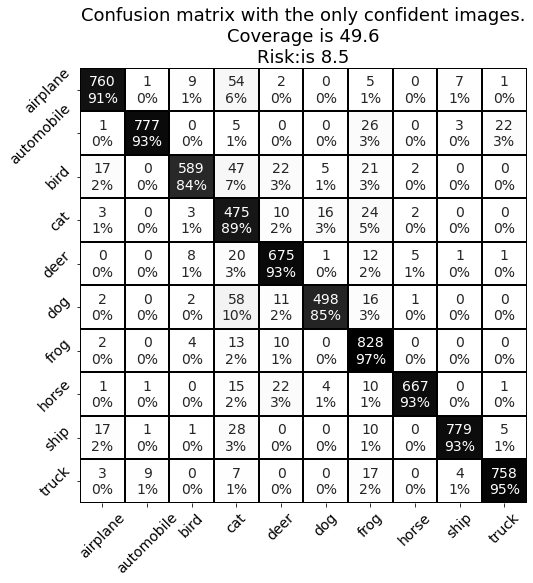

In [28]:
cm = confusion_matrix(true_labels[variance>theta], 
                      np.argmax(preds_averaged, axis=1)[variance>=theta])
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
seaborn_cm(cm, ax, categorical_labels)
ax.set_title("Confusion matrix with the only confident images.\nCoverage is {:.1f}\nRisk:is {:.1f}".format(
    sum(variance>theta)/len(variance)*100,
    100 - np.sum(np.diag(cm)) / sum(variance>theta) * 100));

# Out-of-distribution
Load the data from the following filepath and make a tf dataset

## TTA

In [29]:
filepath = os.path.join(ROOTDIR_DATA, "ood.npy")
ood = np.load(filepath)
label_ood = np.zeros(len(ood))

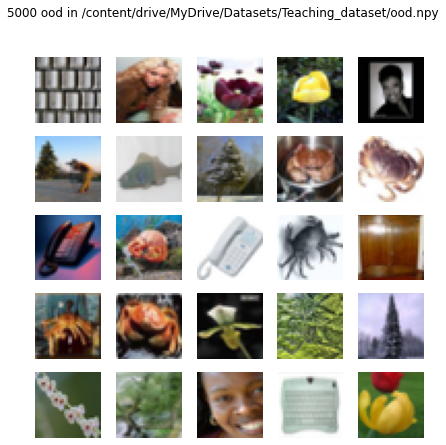

In [30]:
ood_ds = tf.data.Dataset.from_tensor_slices((ood, label_corr))
ood_ds = ood_ds.shuffle(buffer_size=len(ood))
fig, ax = plt.subplots(5, 5, figsize=(7, 7))
ax = ax.ravel()
j = 0
for x, y in ood_ds.take(25):
    ax[j].imshow(x.numpy())
    ax[j].axis('off')
    j += 1
fig.suptitle("{} ood in {}".format(len(ood), filepath));
ood_ds = ood_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
ood_ds = ood_ds.cache()
ood_ds = ood_ds.batch(128)
ood_ds = ood_ds.prefetch(tf.data.AUTOTUNE)

In [31]:
multiple_preds = tta_model.predict_many_times(ood_ds, "all", draws=draws)

In [32]:
uncertainty_tta_ood = tta_model.uncertainty_metrics(np.array(multiple_preds))

Done entropy
Done variance
Done max_softmax_response


Compute unceertainty metrics for TTA 

## MC dropout

In [33]:
input_shape = (32, 32, 3)
num_classes = 10
draws = 20 #  Equivalent with 'all' as TTA policy (this means draws*4 total samples, with draws set as 5)

MC Wrapper

In [34]:
class MCWrapper(tf.keras.Model):

    def __init__(self, keras_model):
        super(MCWrapper, self).__init__()
        self.model = keras_model
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(
            metric, 
            multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
            return (values - values.min())/(values.max()-values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(
                self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        return np.array([self.model.predict(inputs) for _ in range(draws)])

    def _avreage_prediction(self, multiple_preds):
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
            return multiple_preds

    def _variance(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return  np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._avreage_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

In [35]:
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes,
               mc_dropout=True,
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar_mc-drop/checkpoint_cifar10_lr_red"))
mc_model = MCWrapper(model)

Test the model on cifar10 original

In [36]:
results_cifar = mc_model.model.evaluate(cifar10_test, verbose=0)
print("Accuracy on cifar10 test set: {:.2f}".format(results_cifar[1]))

Accuracy on cifar10 test set: 0.82


In [37]:
multiple_preds = mc_model.predict_many_times(ood_ds, draws=draws)

Compute uncertainty metrics for MC dropout

In [38]:
uncertainty_mc_ood = mc_model.uncertainty_metrics(np.array(multiple_preds))

Done variance
Done max_softmax_response


Compute deterministic preds by loading again deterministic model and compute deterministic uncertainties

In [39]:
input_shape = (32, 32, 3)
num_classes = 10
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes, 
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar/checkpoint_cifar10_lr_red"))

In [40]:
deterministic_preds_ood = model.predict(ood_ds)

In [41]:
uncertainty_deterministc_ood = mc_model.uncertainty_metrics(deterministic_preds_ood)

Done variance
Done max_softmax_response


Plot histograms comparing the different metrics (MC, TTA, deterministic) on the OOD

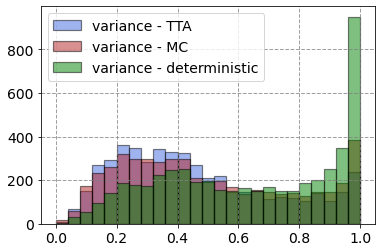

In [42]:
fig, ax = plt.subplots(1, 1)
ax.hist(uncertainty_tta_ood['variance'],
        color="royalblue", 
        log=False, 
        bins=25, 
        edgecolor='black',
        label="variance - TTA",
        linewidth=1.2, 
        alpha=0.5);
ax.hist(uncertainty_mc_ood['variance'],
        color="firebrick", 
        log=False, 
        bins=25, 
        edgecolor='black',
        label="variance - MC",
        linewidth=1.2, 
        alpha=0.5);
ax.hist(uncertainty_deterministc_ood['variance'],
        color="green", 
        log=False, 
        bins=25, 
        edgecolor='black',
        label="variance - deterministic",
        linewidth=1.2, 
        alpha=0.5);
ax.legend();